In [155]:
import cv2
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math

RECT_PATH = "rect.jpeg"
img = cv2.imread(RECT_PATH)

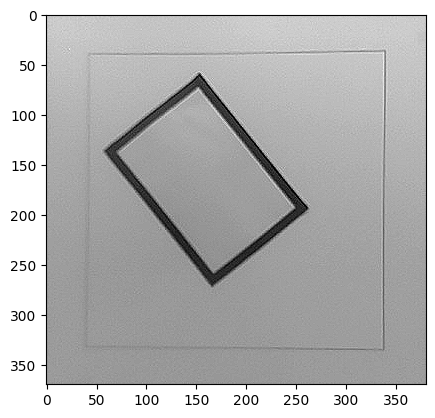

In [156]:
grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
sharped = cv2.filter2D(grey, -1, kernel)
plt.imshow(sharped, cmap='gray')

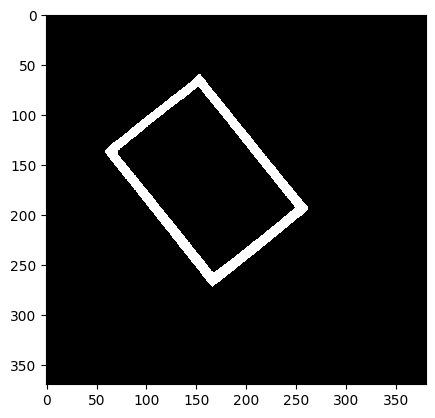

In [157]:
res, binary = cv2.threshold(grey, 80, 255, cv2.THRESH_BINARY_INV)
plt.imshow(binary, cmap='gray')

array([[[151,  72]],

       [[249, 193]],

       [[168, 258]],

       [[ 71, 140]]], dtype=int32)

array([[[152,  60]],

       [[ 59, 138]],

       [[166, 272]],

       [[261, 192]]], dtype=int32)

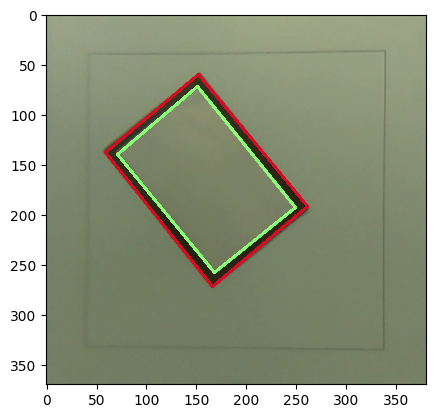

In [159]:
res = img.copy()
contours, hierarchy = cv2.findContours(binary, cv2.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
# https://docs.opencv.org/4.8.0/d4/d73/tutorial_py_contours_begin.html
# https://docs.opencv.org/4.8.0/d3/dc0/group__imgproc__shape.html#ga17ed9f5d79ae97bd4c7cf18403e1689a
# https://docs.opencv.org/4.8.0/dd/d49/tutorial_py_contour_features.html?loclr=blogmap

from typing import List, Tuple, Optional, Iterator, Iterable
def get_nearest_point(point: Tuple[float, float], points: Iterable[Tuple[float, float]]):
    x_1, y_1 = point
    min_dist: Optional[float] = None
    nearest_point: Optional[Tuple[float, float]] = None
    for x_2, y_2 in points:
        dist = math.sqrt((x_1 - x_2) ** 2 + (y_1 - y_2) ** 2)
        if min_dist is None or dist < min_dist:
            min_dist = dist
            nearest_point = (x_2, y_2)
    return nearest_point

Point = Tuple[float, float]
from functools import reduce
def bind_points(xs:List[Point], ys:List[Point]) -> List[Tuple[Point, Point]]:
    assert len(xs) == len(ys)
    ret = reduce(lambda acc, x: acc + [(x, get_nearest_point(x, ys))], xs, [])
    return list(ret)


import random
rects = []
for c in contours:
    approx = cv2.approxPolyDP(c, 0.01 * cv2.arcLength(c, True), True)
    if len(approx) == 4:
        display(approx)
        if len(approx):
            res = cv2.drawContours(res, [approx], 0, (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)), 2)
            rects.append(rects)


plt.imshow(res)